We think of this if we reach it

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as scp
from copy import deepcopy

In [2]:
# Parameters
L = 28  # Lenght of the edge of the image
N = L**2 # Number of spins 
p = 10 # Number of patterns
MF = 0 # Use or not the Mean Field strategy: if MF=1 uses MF, if MF = 0 only spins at
# a distance R interacts
R = 3 # The 3-nearest neighbor interacts
np.random.seed(1234) # Seed to make the random process reproducible

In [3]:
# Function that are in previous notebook
def random_patterns(N,p):
    xi = np.random.randint(0,2,N*p).reshape(p,N) # Each line is a pattern
    xi[xi==0]=-1
    return xi

def MF_coupling(xi,N):
    J = 1/N * np.array( [ (xi[:,i]*xi[:,j]).sum() for i in range(N) for j in range(N) ] )
    J = J.reshape(N,N)        
    for i in range(len(J)):
        J[i,i] = 0
    return J

def R_coupling(xi,N,R):
    J = MF_coupling(xi,N)
    L = int(np.sqrt(N))
    for i in range( J.shape[0] ):
        J_temp = J[i].reshape(L,L)
        for j in range(L):
            y = (i%L -j)**2 # Look at indexes should be ok -1
            for k in range(L):
                if np.sqrt( (i//L - k)**2 + y ) > R: J_temp[j,k] = 0
        J[i] = J_temp.reshape(1,N)
    return J

def update(sys1):
    sys = deepcopy(sys1)
    N = len(sys)
    for i in range(N):
        temp = 0
        for j in range(N): #Maybe it is possible to set the cycle on J[i][j]!=0 only
            temp +=  J[i][j]*sys[j] 
        sys[i] = np.sign(temp)
    return np.sign(sys)

def deterministic_hopfield(sys1, t):
    sys = deepcopy(sys1)
    for i in range(t):
        sys = update(sys)
    return sys

def error_im(xi_idx, sys):
    wrong_pixels = (np.abs( sys-xi_idx )/2).sum()
    return wrong_pixels/len(sys)

def assign_pattern(xi,sys):
    errors = [ error_im(i,sys) for i in xi ]
    correct = np.argmin(errors)
    return correct

def total_error(xi,t):
    errors = []
    prediction = []
    for mu in range(len(xi)):
        sys = deterministic_hopfield(xi[mu],t)
        errors.append( error_im(xi[mu],sys) )
        if assign_pattern(xi,sys)==mu:
            prediction.append( 1 )
        else: prediction.append( 0 )
    errors = (np.array(errors)).mean()
    prediction = np.array(prediction).sum()/len(xi)
    return errors, prediction

def corrupt_uniform(sys, q): # q probability to flip the pixel
    sys_temp = deepcopy(sys)
    N = sys.shape[0]
    for i in range(N):
        r = np.random.rand()
        if r < q:
            sys_temp[i] *= -1
    return sys_temp

def H(J,sys):
    N = sys.shape[0]
    energy = 0
    for i in range(N):
        for j in range(i):
            energy -= J[i][j]*sys[i]*sys[j]
    return energy

# Mean Field version of dH
def dH(J, sys, k): # k is the index of the spin flipped
    N = sys.shape[0]
    dh = 0
    for i in range(N):
        dh += sys[i]*J[k][i]
    dh *= 2*sys[k]
    return dh

def metropolis(J, sys1, k, B): # B = 1/kbT temperature of the system
    sys = deepcopy(sys1)
    dh = dH(J, sys, k)
    r = np.random.rand() # random variable between (0,1)
    if r < np.exp( -B*dh ):
        sys[k] = -sys[k]
    return sys
    
def montecarlo(J, sys1, B, t ): # t number of iteration of the montecarlo
    sys = deepcopy(sys1)
    N = sys.shape[0]
    for i in range(t):
        k = np.random.randint(0,N)
        sys = metropolis(J, sys, k, B)
    return sys

def perpendicolar_nn(J, sys, k, r):
    dh = 0
    l = int(np.sqrt(sys.shape[0]))
    for i in range(k+1,k+r+1): # going right
        if k%l == l-1: break # right bound
        dh += J[i][k]*sys[i]
        if i%l == l-1: break # last column bound
            
    for i in range(k-1,k-r-1,-1): # going left
        if k%l == 0: break # left bound
        dh += J[i][k]*sys[i]
        if i%l == 0: break # first column bound
            
    for i in range(k+l,k+(r+1)*l,l): # going down
        if k//l == l-1: break # low bound
        dh += J[i][k]*sys[i]
        if i//l ==l-1 : break # last row bound
            
    for i in range(k-l, k-l*(r+1), -l): # going up
        if k//l == 0: break # up bound
        dh += J[i][k]*sys[i]
        if i//l == 0: break  # first row bound
    return dh
            
def diagonal_nn(J, sys, k, r):
    dh = 0
    l = int(np.sqrt(sys.shape[0]))
    for i in range(1,r):
        if k%l == l-1 or k//l == l-1: break # right low bound
        for j in range(1,r):
            if i==j==r-1: continue
            dh += J[k+j+i*l][k]*sys[k+j+i*l]  # right low
            if (k+j+i*l)%l == l-1 : break # last column bound
        if (k+j+i*l)//l ==l-1 : break # last row bound
        
    for i in range(1,r):
        if k%l == 0 or k//l == l-1: break # left low bound
        for j in range(1,r):
            if i==j==r-1: continue
            dh += J[k-j+i*l][k]*sys[k-j+i*l]  # left low
            if (k-j+i*l)%l == 0 : break #  first column bound
        if (k-j+i*l)//l ==l-1 : break # last row bound
        
    for i in range(1,r):
        if k//l == 0 or k%l == l-1: break # up right bound
        for j in range(1,r):
            if i==j==r-1: continue
            dh += J[k+j-i*l][k]*sys[k+j-i*l] # right up
            if (k+j-i*l)%l == l-1: break  # last column bound
        if (k+j-i*l)//l == 0: break # first row bound
        
    for i in range(1,r):
        if k//l == 0 or k%l == 0 : break # up left bound
        for j in range(1,r):
            if i==j==r-1: continue
            dh += J[k-j-i*l][k]*sys[k-j-i*l] # left up
            if (k-j-i*l)%l == l-1: break  #last column bound
        if (k-j-i*l)//l == 0 : break # first row bound
    return dh

def not_MF_dH(J, sys, k, R):
    dh = perpendicolar_nn(J, sys, k, R) + diagonal_nn(J, sys, k, R)
    dh *= 2*sys[k]
    return dh

def not_MF_metropolis(J, sys1, k, B, R): # B = 1/kbT temperature of the system
    sys = deepcopy(sys1)
    dh = not_MF_dH(J, sys, k, R)
    r = np.random.rand() # random variable between (0,1)
    if r < np.exp( -B*dh ):
        sys[k] = -sys[k]
    return sys

def not_MF_montecarlo(J, sys1, B, R, t ): # t number of iteration of the montecarlo
    sys = deepcopy(sys1)
    N = sys.shape[0]
    for i in range(t):
        k = np.random.randint(0,N)
        sys = not_MF_metropolis(J, sys, k, B, R)
    return sys

def corrupt_norm(sys, k, h):
    sys_temp = deepcopy(sys)
    N = sys.shape[0]
    L = int(np.sqrt(N))
    sys_temp = sys_temp.reshape(L,L)
    for i in range(L):
        for j in range(L):
            g = gaus(k, L/5, h, i, j)
            r = np.random.rand()
            if r < g:
                sys_temp[i][j] *= -1
    return (sys_temp.reshape(1,N))[0]

def gaus(mu, sigma, h, x, y):
    h = np.sqrt(h)
    g_x = np.exp(-( (x-mu[0])**2 / ( 2.0 * sigma**2 ) ) )*h#/np.sqrt(2*np.pi*sigma**2)
    g_y = np.exp(-( (y-mu[1])**2 / ( 2.0 * sigma**2 ) ) )*h#/np.sqrt(2*np.pi*sigma**2)
    g = g_y * g_x
    return g

In [4]:
def from_minst_to_spin(X):
    X = X/255 # Normalizing the values 
    X[ X<0.2 ] = -1
    X[ X>=0.2 ] = 1
    return X

In [5]:
# Just rewrite the path if you want to try it
data_train = pd.read_csv('/Users/Marco/Desktop/data/mnist_train.csv')
data_test = pd.read_csv('/Users/Marco/Desktop/data/mnist_test.csv')

In [6]:
# Actually I didn't use them since they are too much
label_train = []
digits_train = []
for i in range(data_train.shape[0]):
    a = np.array( data_train.iloc[ [i] ])
    label_train.append( a[0][0])
    digits_train.append( a[0][1:] )

label_train = np.array(label_train)
digits_train = np.array(digits_train)
X_train = from_minst_to_spin(digits_train) # from value to {-1,1}

In [7]:
# Used them even if test since less
label_test = []
digits_test = []
for i in range(data_test.shape[0]):
    a = np.array( data_test.iloc[ [i] ])
    label_test.append( a[0][0])
    digits_test.append( a[0][1:] )

label_test = np.array(label_test)
digits_test = np.array(digits_test)
X_test = from_minst_to_spin(digits_test)

In [8]:
# Try with patterns that are the average over all the digits.
# For example take the all 0, sum over the pixel and divide for the number of images.
# If the value is negative -> -1, the other case 1
mean_patterns = []
for i in range(10):
    mean_patterns.append( from_minst_to_spin(X_test[ label_test == i ].sum(axis=0)) )
mean_patterns = np.array(mean_patterns)

In [8]:
# Just select random samples as patterns
rand_patterns = []
for i in range(10):
    temp = X_test[ label_test == i ].shape[0]
    temp = np.random.randint(0,temp)
    rand_patterns.append( X_test[ label_test == i ][temp] )
rand_patterns = np.array(rand_patterns)

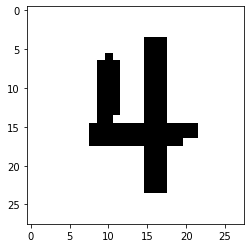

In [20]:
plt.imshow( rand_patterns[4].reshape(L,L), cmap='Greys' )

In [ ]:
# Average pattern try
# It does not work. Look at it if you want. I think patterns are too much similar
# Also average patterns are not too good. 
idx = np.random.randint(0,9999)
dgt = label_test[idx]

sys = X_test[idx]

res = montecarlo(J,sys,10,1000)

wrong_pixels = error_im(mean_patterns[dgt],sys)
assigned_pattern = assign_pattern(mean_patterns,sys)


fig, ax = plt.subplots(1,4, figsize=(10,6))
ax[0].set_title('Original pattern')
ax[0].imshow(mean_patterns[dgt].reshape(L,L),cmap='Greys')
ax[1].set_title('Handwritten digit')
ax[1].imshow(sys.reshape(L,L),cmap='Greys')
ax[2].set_title('Recovered digit')
ax[2].imshow(res.reshape(L,L),cmap='Greys')
ax[3].set_title('Recognised digit')
ax[3].imshow(mean_patterns[assigned_pattern].reshape(L,L),cmap='Greys')
print('The error of the algorithm is %f' %(wrong_pixels))
print('The algorithm recognised the pattern %i and the correct pattern is %i' %(assigned_pattern,dgt))

In [ ]:
J = MF_coupling(rand_patterns,N)

In [ ]:
# Random pattern try
# Slightly better, still not good

idx = np.random.randint(0,9999)
dgt = label_test[idx]

sys = X_test[idx]

#res = montecarlo(J,sys,100,10000)
res = deterministic_hopfield(sys, 500)

wrong_pixels = error_im(rand_patterns[dgt],sys)
assigned_pattern = assign_pattern(rand_patterns,sys)


fig, ax = plt.subplots(1,4, figsize=(10,6))
ax[0].set_title('Original pattern')
ax[0].imshow(rand_patterns[dgt].reshape(L,L),cmap='Greys')
ax[1].set_title('Handwritten digit')
ax[1].imshow(sys.reshape(L,L),cmap='Greys')
ax[2].set_title('Recovered digit')
ax[2].imshow(res.reshape(L,L),cmap='Greys')
ax[3].set_title('Recognised digit')
ax[3].imshow(rand_patterns[assigned_pattern].reshape(L,L),cmap='Greys')
print('The error of the algorithm is %f' %(wrong_pixels))
print('The algorithm recognised the pattern %i and the correct pattern is %i' %(assigned_pattern,dgt))

## Zipping the images

In [14]:
# Just thought that maybe there was too much pixels to understand the behaviour.
# This function takes batches of four pixels and from them create a single pixel
# that is black if even only one of that four is black.
# This divides by 4 the resolution of the image, 28x28->14x14

def zipping(sys1):
    sys = deepcopy(sys1)
    N = sys.shape[0]
    L = int(np.sqrt(N))
    sys = sys.reshape(L,L)
    zipp = np.array([-1 for i in range(N//4)]).reshape(L//2,L//2)
    for i in np.arange(0, L, 2):
        for j in np.arange(0, L, 2):
            if sys[i][j] + sys[i+1][j] + sys[i][j+1] + sys[i+1][j+1] > -4:
                zipp[i//2,j//2] = 1
    zipp = zipp.reshape(1,N//4)
    return zipp[0]

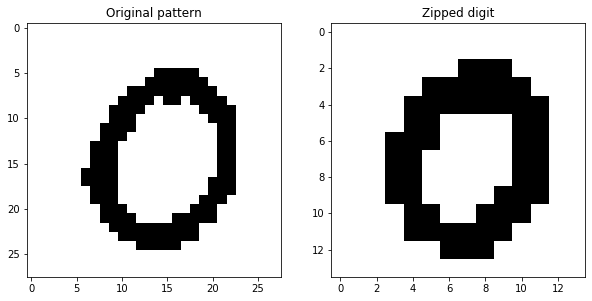

In [15]:
# Simply look at the outcome
idx = 100
dgt = label_test[idx]
sys = X_test[idx]

zip_dgt = zipping(sys)

fig, ax = plt.subplots(1,2, figsize=(10,6))
ax[0].set_title('Original pattern')
ax[0].imshow(sys.reshape(L,L),cmap='Greys')
ax[1].set_title('Zipped digit')
ax[1].imshow(zip_dgt.reshape(L//2,L//2),cmap='Greys')

In [16]:
# Yeah, you know I really love to use the word stuff. I was only upset that this 
# stuff wasn't working. Here I zip all the test data.
X_zip = []
for i in X_test:
    X_zip.append( zipping(i) )
X_zip = np.array(X_zip)

In [17]:
# Inizialize the old variables using the new zipped samples.

rand_patterns = []
for i in range(10):
    temp = X_zip[ label_test == i ].shape[0]
    temp = np.random.randint(0,temp)
    rand_patterns.append( X_zip[ label_test == i ][temp] )
rand_patterns = np.array(rand_patterns)

n = N//4
J = R_coupling(rand_patterns[0:3],n,5)

In [ ]:
idx = np.random.randint(0,9999)
dgt = label_test[idx]

sys = X_zip[idx]

new = montecarlo(J,sys,25,1000)
#res = deterministic_hopfield(sys, 100)

wrong_pixels = error_im(rand_patterns[dgt],new)
assigned_pattern = assign_pattern(rand_patterns,new)


fig, ax = plt.subplots(1,4, figsize=(10,6))
ax[0].set_title('Original pattern')
ax[0].imshow(rand_patterns[dgt].reshape(L//2,L//2),cmap='Greys')
ax[1].set_title('Handwritten digit')
ax[1].imshow(sys.reshape(L//2,L//2),cmap='Greys')
ax[2].set_title('Recovered digit')
ax[2].imshow(new.reshape(L//2,L//2),cmap='Greys')
ax[3].set_title('Recognised digit')
ax[3].imshow(rand_patterns[assigned_pattern].reshape(L//2,L//2),cmap='Greys')
print('The error of the algorithm is %f' %(wrong_pixels))
print('The algorithm recognised the pattern %i and the correct pattern is %i' %(assigned_pattern,dgt))

# Find the real minima of the system

In [ ]:
# First I create 1000 random samples
X_created = []
for i in range(1000):
    X_created.append( 2*np.random.randint(0,2,14*14)-1 )

# The I run the algorithm for all of them, 500 iterations each
X_hop = X_created
for i in range(1000):
    X_hop[i] = montecarlo(J, X_created[i], 25, 500)


In [97]:
# Now I look at the errors between each of them. I store all of them with error 
# greater than a certain amount.
minima = []
X_min = deepcopy(X_hop)
while( len(X_hop) != 0 ):
    minima.append(X_min[0])
    X_min = X_min[ error_im(X_min[0],X_min) > 0.1 ]
    print('ciao')

ciao
ciao
ciao


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  import sys


IndexError: index 0 is out of bounds for axis 0 with size 0

In [105]:
minima[2]

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1,
        1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1,  1, -1,  1,  1, -1, -1, -1, -1, -1, -1,  1, -1,
       -1, -1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1,
        1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1,
        1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1, -1, -1,
       -1, -1, -1, -1, -1,  1,  1,  1,  1, -1, -1,  1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1,  1, -1, -1, -1])

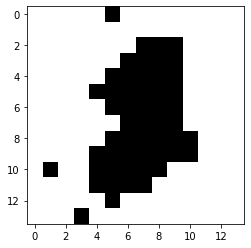

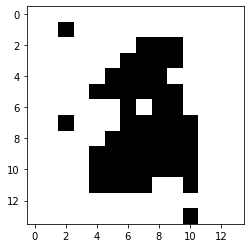

In [113]:
# And now I can look at the true minima of the system:
for i in range(0,len(minima),2):
    plt.imshow( minima[i].reshape(14,14), cmap='Greys' )
    plt.show()

In [41]:
err = []
patt = []
diff = []

for n in range(100):
    idx = np.random.randint(0,9999)
    dgt = label_test[idx]
    sys = X_zip[idx]
    res = montecarlo(J,sys,100,1000)
    inv = error_im(new ,res)
    diff.append(inv)
    wrong_pixels = error_im(rand_patterns[dgt],res)
    err.append(wrong_pixels)
    assigned_pattern = assign_pattern(rand_patterns,res)
    patt.append(assigned_pattern)

In [42]:
err = np.array(err)
diff = np.array(diff)
patt = np.array(patt)

## Hopfield-chain algorithm

In [18]:
# First we want to abbine the most different patterns.
# We compute so an "error matrix"
err_mat = []
for i in range(10):
    err_mat.append([])
    for j in range(10):
        err_mat[i].append( round(error_im(rand_patterns[i], rand_patterns[j]),2) )
err_mat = np.array(err_mat).reshape(10,10)
err_mat

array([[0.  , 0.3 , 0.26, 0.23, 0.24, 0.29, 0.24, 0.29, 0.22, 0.24],
       [0.3 , 0.  , 0.24, 0.15, 0.12, 0.29, 0.19, 0.15, 0.18, 0.18],
       [0.26, 0.24, 0.  , 0.22, 0.22, 0.35, 0.15, 0.31, 0.23, 0.25],
       [0.23, 0.15, 0.22, 0.  , 0.22, 0.25, 0.2 , 0.21, 0.15, 0.22],
       [0.24, 0.12, 0.22, 0.22, 0.  , 0.29, 0.14, 0.19, 0.16, 0.17],
       [0.29, 0.29, 0.35, 0.25, 0.29, 0.  , 0.29, 0.29, 0.23, 0.26],
       [0.24, 0.19, 0.15, 0.2 , 0.14, 0.29, 0.  , 0.21, 0.16, 0.17],
       [0.29, 0.15, 0.31, 0.21, 0.19, 0.29, 0.21, 0.  , 0.21, 0.13],
       [0.22, 0.18, 0.23, 0.15, 0.16, 0.23, 0.16, 0.21, 0.  , 0.16],
       [0.24, 0.18, 0.25, 0.22, 0.17, 0.26, 0.17, 0.13, 0.16, 0.  ]])

In [19]:
# Selecting couples with higher differences
best = []
for i in range(10):
    best.append( [i ,np.argmax( err_mat[i] )] )

# Eliminating symmetric couples
best = np.unique(np.sort(best, axis=1), axis=0)
best 

array([[0, 1],
       [2, 5],
       [2, 7],
       [2, 8],
       [3, 5],
       [4, 5],
       [5, 6],
       [5, 9]])

In [20]:
# Computing the couplings for the various connections
Ji = []
for i in best:
    patt = np.array( [  rand_patterns[i[0]], rand_patterns[i[1]] ] )
    Ji.append( R_coupling( patt ,N//4, 7) ) 

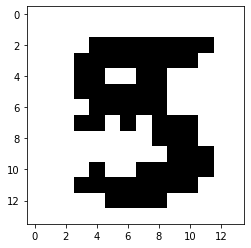

In [70]:
plt.imshow( treee[2].reshape(14,14), cmap='Greys' )

# Average for each digits

In [55]:
# Look at different digit convergenge time
ordered_digits = []
for i in range(10):
    ordered_digits.append( X_zip[ label_test == i ] )

iterations = np.arange(200,600,50)

err = []
err_dev = []
for i in range(3,4): # cycle over the digits
    err.append( [] )
    err_dev.append( [] )
    for t in iterations: # cycle over iterations
        temp_err = []
        for n in range(10): # iterations
            for j in range(len(best)): # Selection of correct coupling
                if i in best[j]:
                    sys = ordered_digits[i][n]
                    res = montecarlo(Ji[j], sys ,25 , t)
                    wrong_pixels = error_im(rand_patterns[i], res)
                    temp_err.append(wrong_pixels)
                    break
        temp_err = np.array(temp_err)
        err[i].append( temp_err.mean() )
        err_dev[i].append( temp_err.std() )

IndexError: list index out of range

Text(0.5, 1.0, 'Speed of convergence for each digit')

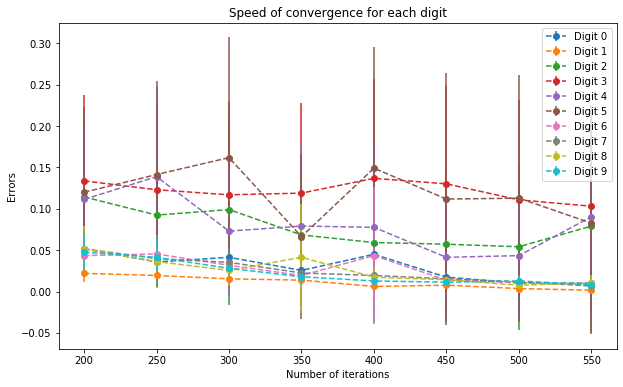

In [45]:
fig = plt.figure( figsize=(10,6) )
for i in range(10):
    label = ('Digit %i' %i)
    plt.errorbar( iterations, err[i],fmt='--o', yerr=err_dev[i],  label = label )
plt.xlabel('Number of iterations')
plt.ylabel('Errors')
plt.legend(loc='best')
plt.title('Speed of convergence for each digit')

In [190]:
# Try with just one sample
idx = np.random.randint(0,9999)
dgt = label_test[idx]

for i in range(len(best)):
    sys = X_zip[idx]
    res = montecarlo(Ji[i], sys ,25 , 1000)

    wrong_pixels = error_im(rand_patterns[dgt], res)

    if wrong_pixels > 0.10 and i<8: 
        continue
    patt = np.array( [  rand_patterns[best[i][0]], rand_patterns[best[i][1]] ] )
    assigned_pattern = assign_pattern(patt, res) 
    assigned_pattern = best[i][assigned_pattern] 
    break

print('The error of the algorithm is %f' %(wrong_pixels))
print('The algorithm recognised the pattern %i and the correct pattern is %i' %(assigned_pattern,dgt))

The error of the algorithm is 0.000000
The algorithm recognised the pattern 3 and the correct pattern is 3


In [195]:
err = []
score = 0
for n in range(100):
    idx = np.random.randint(0,9999)
    dgt = label_test[idx]

    for i in range(len(best)):
        sys = X_zip[idx]
        res = montecarlo(Ji[i], sys ,25 , 500)

        wrong_pixels = error_im(rand_patterns[dgt], res)

        if wrong_pixels > 0.10 and i<8: 
            continue
        patt = np.array( [  rand_patterns[best[i][0]], rand_patterns[best[i][1]] ] )
        assigned_pattern = assign_pattern(patt, res) 
        assigned_pattern = best[i][assigned_pattern] 
        break
    err.append(wrong_pixels)
    if assigned_pattern == dgt: score += 1


In [196]:
err = np.array(err)
score /= 100
print('The score of the algorithm is %f with an average error of %f' %(score, err.mean()))

The score of the algorithm is 0.890000 with an average error of 0.030102


In [21]:
err = []
score = 0
for n in range(len(X_zip)):
    idx = n
    dgt = label_test[idx]

    for i in range(len(best)):
        sys = X_zip[idx]
        res = montecarlo(Ji[i], sys ,25 , 500)

        wrong_pixels = error_im(rand_patterns[dgt], res)

        if wrong_pixels > 0.10 and i<8: 
            continue
        patt = np.array( [  rand_patterns[best[i][0]], rand_patterns[best[i][1]] ] )
        assigned_pattern = assign_pattern(patt, res) 
        assigned_pattern = best[i][assigned_pattern] 
        break
    err.append(wrong_pixels)
    if assigned_pattern == dgt: score += 1

err = np.array(err)
score /= len(X_zip)
print('The score of the algorithm is %f with an average error of %f' %(score, err.mean()))

The score of the algorithm is 0.933893 with an average error of 0.027611


## Old, non-optimized version of the hopfield-chain

In [188]:
idx = np.random.randint(0,9999)
dgt = label_test[idx]

for i in range(0,10,2):
    #sys = X_zip[idx]
    sys = corrupt_norm(X_zip[idx], [L//4,L//4], 0.2 )
    res = montecarlo(Ji[i//2],sys ,25 , 1000)

    wrong_pixels = error_im(rand_patterns[dgt],res)
    print(i)
    if wrong_pixels > 0.10 and i<8: 
        continue
    assigned_pattern = assign_pattern(rand_patterns[i:i+2],res) 
    #print(assigned_pattern)
    assigned_pattern += i
    #print(assigned_pattern)
    break

print('The error of the algorithm is %f' %(wrong_pixels))
print('The algorithm recognised the pattern %i and the correct pattern is %i' %(assigned_pattern,dgt))

0
The error of the algorithm is 0.000000
The algorithm recognised the pattern 0 and the correct pattern is 0


In [152]:
err = []
score = 0
for n in range(100):
    idx = np.random.randint(0,9999)
    dgt = label_test[idx]

    for i in range(0,10,2):
        sys = X_zip[idx]
        #sys = corrupt_norm(X_zip[idx], [L//4,L//4], 0.2 )
        res = montecarlo(Ji[i//2],sys ,25 , 1000)
        wrong_pixels = error_im(rand_patterns[dgt],res) 
        
        if wrong_pixels > 0.10 and i<8: 
            continue
            
        assigned_pattern = assign_pattern(rand_patterns[i:i+2],res) 
        assigned_pattern += i
        break
    err.append(wrong_pixels)
    if assigned_pattern == dgt: score += 1
    

In [153]:
err = np.array(err)
score /= 100
print('The score of the algorithm is %f with an average error of %f' %(score, err.mean()))

The score of the algorithm is 0.700000 with an average error of 0.056684


# Error with vicinanza

In [92]:
def w_error(sys11, sys22, alpha):
    sys1 = deepcopy(sys11)
    sys2 = deepcopy(sys22)
    N = sys1.shape[0]
    L = int(np.sqrt(N))
    sys1 = sys1.reshape(L,L)
    sys2 = sys2.reshape(L,L)
    wrong1 = []
    wrong2 = []
    min_dist = []
    for i in range(L):
        for j in range(L):
            if sys1[i][j] == sys2[i][j]: continue
            elif sys1[i][j]== 1 : 
                wrong1.append( np.array([i,j]) )
            elif sys2[i][j]== 1:
                wrong2.append( np.array([i,j]) )
    for i in wrong1:
        distances = []
        for j in wrong2:
            if np.linalg.norm(i-j) !=0 :
                distances.append( np.linalg.norm(i-j) )
        if len(distances)==0 : min_dist.append(np.exp(1000))
        else: min_dist.append( np.array(distances).min() )
    min_dist = np.array(min_dist)
    err =  (1/(min_dist)**alpha).sum()
    err /= (N+1)//2
    return err

def tot_err(sys11, sys22):
    err = error_im(sys11, sys22) + 2*w_error(sys11, sys22, 2)
    return err/2

def assign_digit(xi,sys):
    errors = [ tot_err(i,sys) for i in xi ]
    correct = np.argmin(errors)
    return correct

In [93]:
# First we want to abbine the most different patterns.
# We compute so an "error matrix"
err_mat = []
for i in range(10):
    err_mat.append([])
    for j in range(10):
        err_mat[i].append( round(tot_err(rand_patterns[i], rand_patterns[j]),2) )
err_mat = np.array(err_mat).reshape(10,10)

# Selecting couples with higher differences
best = []
for i in range(10):
    best.append( [i ,np.argmax( err_mat[i] )] )

# Eliminating symmetric couples
best = np.unique(np.sort(best, axis=1), axis=0)

# Computing the couplings for the various connections
Ji = []
for i in best:
    patt = np.array( [  rand_patterns[i[0]], rand_patterns[i[1]] ] )
    Ji.append( R_coupling( patt ,N//4, 7) ) 

In [94]:
# Look at different digit convergenge time
ordered_digits = []
for i in range(10):
    ordered_digits.append( X_zip[ label_test == i ] )

iterations = np.arange(200,600,50)

err = []
err_dev = []
for i in range(10): # cycle over the digits
    err.append( [] )
    err_dev.append( [] )
    for t in iterations: # cycle over iterations
        temp_err = []
        for n in range(10): # iterations
            for j in range(len(best)): # Selection of correct coupling
                if i in best[j]:
                    sys = ordered_digits[i][n]
                    res = montecarlo(Ji[j], sys ,25 , t)
                    wrong_pixels = tot_err(rand_patterns[i], res)
                    temp_err.append(wrong_pixels)
                    break
        temp_err = np.array(temp_err)
        err[i].append( temp_err.mean() )
        err_dev[i].append( temp_err.std() )

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in exp


Text(0.5, 1.0, 'Speed of convergence for each digit')

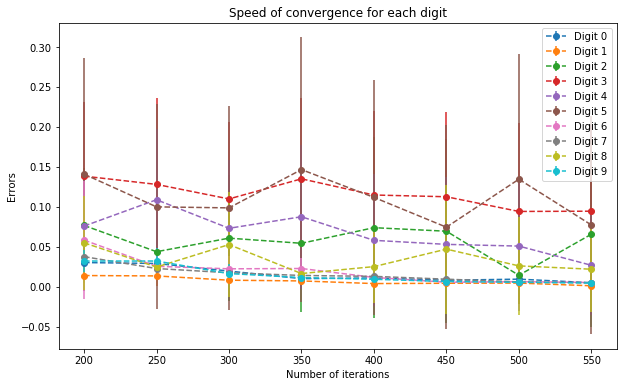

In [95]:
fig = plt.figure( figsize=(10,6) )
for i in range(10):
    label = ('Digit %i' %i)
    plt.errorbar( iterations, err[i],fmt='--o', yerr=err_dev[i],  label = label )
plt.xlabel('Number of iterations')
plt.ylabel('Errors')
plt.legend(loc='best')
plt.title('Speed of convergence for each digit')

In [101]:
err = []
score = 0
for n in range(100):
    idx = np.random.randint(0,9999)
    dgt = label_test[idx]

    for i in range(len(best)):
        sys = X_zip[idx]
        res = montecarlo(Ji[i], sys ,25 , 450)

        wrong_pixels = tot_err(rand_patterns[dgt], res)

        if wrong_pixels > 0.1 and i<8: 
            continue
        patt = np.array( [  rand_patterns[best[i][0]], rand_patterns[best[i][1]] ] )
        assigned_pattern = assign_digit(patt, res) 
        assigned_pattern = best[i][assigned_pattern] 
        break
    err.append(wrong_pixels)
    if assigned_pattern == dgt: score += 1

err = np.array(err)
score /= 100
print('The score of the algorithm is %f with an average error of %f' %(score, err.mean()))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in exp


The score of the algorithm is 0.910000 with an average error of 0.024372
